In [1]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions
import numpy.random as npr
import qutip as qt
import sympy
import random

In [2]:
N=12; J1=1
J2s = np.arange(0, 0.3, 0.005)
# J2s=np.linspace(0, 0.5-0.005, 100)

In [3]:
torch.hstack((utils.generate_input_torch(N), 0.2 * torch.ones((2**12, 1))))

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2000],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2000],
        ...,
        [1.0000, 0.0000, 1.0000,  ..., 1.0000, 1.0000, 0.2000],
        [0.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.2000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.2000]])

In [4]:
gs0 = qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_0.0')
states, _ = utils.get_nonzero_states(N, gs0, 1e-10)

In [5]:
input = torch.vstack([torch.hstack((utils.generate_input_samples(N, states), J2 * torch.ones((len(states), 1)))) for J2 in J2s])
input.shape

torch.Size([55440, 13])

In [6]:
55440 / 924

60.0

In [7]:
all_signs = []
for J2 in J2s:
    gs = qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_{round(J2, 3)}')
    _, signs = utils.get_nonzero_states(N, gs, 1e-10)
    all_signs.append(torch.tensor(signs).reshape(-1, 1))
labels = torch.vstack(all_signs)
labels.shape

torch.Size([55440, 1])

In [8]:
dataset = {'train_input': input, 'train_label': labels, 'test_input': input, 'test_label': labels}

In [9]:
kan_model = kan.KAN(width=[N, N, N, 1])
kan_model(dataset['train_input']);

checkpoint directory created: ./model
saving model version 0.0


In [10]:
kan_model.fit(dataset, steps=50);

description:   0%|                                                           | 0/50 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [13]:
states, signs = utils.get_nonzero_states(N, qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_{round(0.15, 3)}'), 1e-10)# utils.get_nonzero_states(N, qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_{round(0.15, 3)}'), 1e-10)

In [14]:
np.mean((np.array(signs) - np.array([1 - 2 * (magnetization.count_half_magnetization(state) % 2) for state in states])) ** 2)

np.float64(0.05194805194805195)

In [15]:
zero_states, zero_signs = utils.get_nonzero_states(N, qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_0.0'), 1e-10)
zero_map = {k:v for k, v in zip(zero_states, zero_signs)}

In [16]:
N = 12
J1 = 1
J2s = np.arange(0, 0.3, 0.005)

# Prepare input and label arrays for each J2
all_inputs = []
all_signs = []

for J2 in J2s:
    gs = qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_{round(J2, 3)}')
    states, signs = utils.get_nonzero_states(N, gs, 1e-10)
    mapping = {k:v for k, v in zip(states, signs)}
    inputs = torch.hstack((utils.generate_input_samples(N, states), J2 * torch.ones((len(states), 1))))
    all_inputs.append(inputs)
    if mapping[1365] == zero_map[1365]:
        all_signs.append(torch.tensor(signs).reshape(-1, 1))
    else: 
        all_signs.append(-1 * torch.tensor(signs).reshape(-1, 1))

In [48]:
# Now do curriculum learning based on J2 "difficulty"
kan_model = kan.KAN(width=[N, N, N, 1, 1])
kan_model(all_inputs[0])
kan_model.fix_symbolic(3, 0, 0, 'tanh');

input_so_far = []
label_so_far = []

J2_curriculum_steps = [0, 0.1, 0.15, 0.2, 0.25, 0.295]  # progressive J2 thresholds
# J2_curriculum_steps = [0.015, 0.05, 0.1, 0.15, 0.2, 0.25, 0.295]

for threshold in J2_curriculum_steps:
    # Find all J2 indices <= threshold
    eligible = [i for i, J2 in enumerate(J2s) if J2 <= threshold]
    # Combine corresponding inputs and labels
    train_input = torch.vstack([all_inputs[i] for i in eligible])
    train_label = torch.vstack([all_signs[i] for i in eligible])
    dataset = {'train_input': train_input, 'train_label': train_label, 'test_input':train_input, 'test_label':train_label}
    
    print(f"\n[Curriculum Step: Training with {len(eligible)} J2 values up to {threshold}]")
    print(train_input.shape, train_label.shape)
    kan_model.fit(dataset, steps=10, lamb=0);   # You can adjust steps as needed

# Optionally run a final fit over all data 
# this basically does not work

checkpoint directory created: ./model
saving model version 0.0
Best value at boundary.
r2 is 0.9955994486808777
saving model version 0.1

[Curriculum Step: Training with 1 J2 values up to 0]
torch.Size([924, 13]) torch.Size([924, 1])


| train_loss: 9.29e-02 | test_loss: 9.29e-02 | reg: 5.33e+01 | : 100%|█| 10/10 [00:25<00:00,  2.55s/


saving model version 0.2

[Curriculum Step: Training with 21 J2 values up to 0.1]
torch.Size([19404, 13]) torch.Size([19404, 1])


| train_loss: 9.29e-02 | test_loss: 9.29e-02 | reg: 0.00e+00 | :  10%| | 1/10 [00:05<00:53,  5.93s/i


KeyboardInterrupt: 

In [36]:
# Now do curriculum learning based on J2 "difficulty"
kan_model = kan.KAN(width=[N + 1, N, N, 1, 1])
kan_model(all_inputs[0])
kan_model.fix_symbolic(3, 0, 0, 'tanh');

input_so_far = []
label_so_far = []

J2_curriculum_steps = [0]  # progressive J2 thresholds
# J2_curriculum_steps = [0.015, 0.05, 0.1, 0.15, 0.2, 0.25, 0.295]

for threshold in J2_curriculum_steps:
    # Find all J2 indices <= threshold
    eligible = [i for i, J2 in enumerate(J2s) if J2 <= threshold]
    # Combine corresponding inputs and labels
    train_input = torch.vstack([all_inputs[i] for i in eligible])
    train_label = torch.vstack([all_signs[i] for i in eligible])
    dataset = {'train_input': train_input, 'train_label': train_label, 'test_input':train_input, 'test_label':train_label}
    
    print(f"\n[Curriculum Step: Training with {len(eligible)} J2 values up to {threshold}]")
    print(train_input.shape, train_label.shape)
    kan_model.fit(dataset, steps=10, lamb=1e-5);   # You can adjust steps as needed

# Optionally run a final fit over all data

checkpoint directory created: ./model
saving model version 0.0
r2 is 0.9998782277107239
saving model version 0.1

[Curriculum Step: Training with 1 J2 values up to 0]
torch.Size([924, 13]) torch.Size([924, 1])


| train_loss: 1.89e-03 | test_loss: 1.89e-03 | reg: 3.55e+01 | : 100%|█| 10/10 [00:41<00:00,  4.14s/

saving model version 0.2


In [37]:
np.sqrt(np.mean((np.array(all_signs[0]) - kan_model(all_inputs[0]).detach().numpy()) ** 2)) 

C:\Users\taoha\AppData\Local\Temp\ipykernel_23320\4272151177.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.sqrt(np.mean((np.array(all_signs[0]) - kan_model(all_inputs[0]).detach().numpy()) ** 2))


np.float64(0.001888696292616972)

In [38]:
np.sqrt(np.mean((np.array(all_signs[0]) - torch.sgn(kan_model(all_inputs[0])).detach().numpy()) ** 2)) 

C:\Users\taoha\AppData\Local\Temp\ipykernel_23320\385368598.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.sqrt(np.mean((np.array(all_signs[0]) - torch.sgn(kan_model(all_inputs[0])).detach().numpy()) ** 2))


np.float64(0.0)

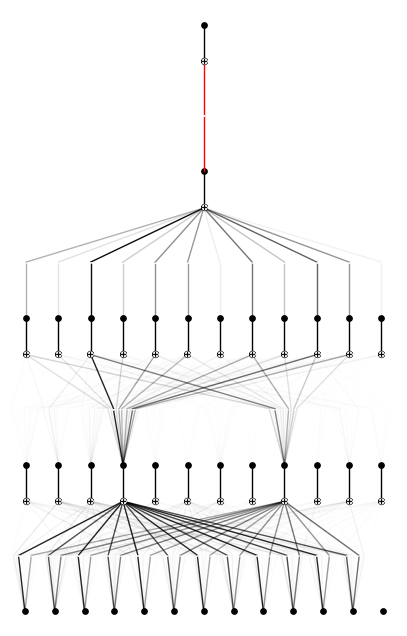

In [42]:
kan_model.plot()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

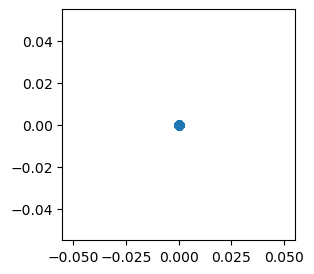

In [44]:
kan_model.get_fun(0, 12, 0)